<a href="https://colab.research.google.com/github/erikstrand2/urban-data-informatics/blob/master/final-project/Stage_III_Travel_characteristics_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express
# Install mapclassify
!pip install mapclassify

# %load_ext google.colab.data_table

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources
Suggested packages:
  python3-setuptools
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
  python3-pkg-resources python3-rtree
0 upgraded, 5 newly installed, 0 to remove and 14 not upgraded.
Need to get 671 kB of archives.
After this operation, 3,948 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 

In [ ]:
!pip install osmnx

     |████████████████████████████████| 92kB 3.6MB/s 
     |████████████████████████████████| 11.6MB 19.6MB/s 
     |████████████████████████████████| 61kB 5.8MB/s 
     |████████████████████████████████| 71kB 7.3MB/s 
  Created wheel for Rtree: filename=Rtree-0.9.4-cp36-none-any.whl size=21765 sha256=021a1b6ba8078530f045a0b8e4bde5ad8c7e0a1ce317e9647f5afacd5f4b08a9
  Stored in directory: /root/.cache/pip/wheels/ff/20/c5/0004ef7acb96745ec99be960053902b0b414a2aa2dcad5834e
Successfully built Rtree
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Found existing installat

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Network analysis for transit accessibility

This part aims to calculate the centrality of each subway station, specifically closeness. Then, the nodes are joined spatially with the NTA using the average centrality. So, we have NTAs with average centrality of their stations.

In [ ]:
import osmnx as ox
import networkx as nx
import pandas as pd
import numpy as np
import geopandas as gpd
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import mapclassify
import matplotlib.cm as cm
import matplotlib.colors as colors
import statsmodels.formula.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Get NTA geofile
NTA = gpd.read_file('https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/ArcGIS/rest/services/NYC_Neighborhood_Tabulation_Areas/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson')

In [ ]:
subway = ox.graph_from_place('Manhattan',
                        retain_all=True, truncate_by_edge=True, simplify = False,
                        custom_filter='["railway"~"subway"]')

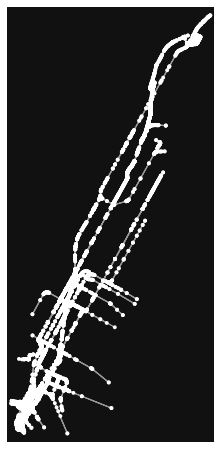

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [ ]:
ox.plot_graph(subway)

In [ ]:
closeness_centrality = nx.closeness_centrality(nx.Graph(subway))
betweenness_centrality = nx.betweenness_centrality(nx.Graph(subway))
degree_centrality = nx.degree_centrality(subway)
nx.degree_histogram(subway)

[0, 0, 134, 0, 6085, 0, 442, 0, 48]

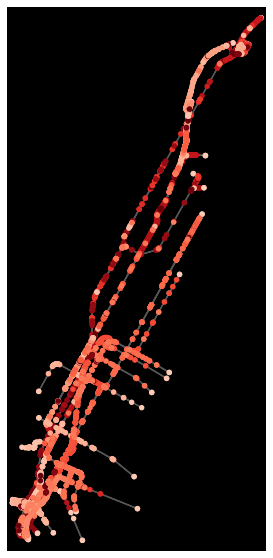

In [ ]:
df = pd.DataFrame(data=pd.Series(degree_centrality).sort_values(), columns=['cc'])
df['colors'] = ox.plot.get_colors(n=len(df), cmap='Reds', start=0.2)
df = df.reindex(subway.nodes())
nc = df['colors'].tolist()
fig, ax = ox.plot_graph(subway, bgcolor='k', node_size=30, node_color=nc, node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1.2, edge_alpha=1,figsize=(10,10))

In [ ]:
# edge_centrality = nx.closeness_centrality(nx.line_graph(subway))
# ev = [edge_centrality[edge + (0,)] for edge in subway.edges()]

# color scale converted to list of colors for graph edges
# norm = colors.Normalize(vmin=min(ev)*0.8, vmax=max(ev))
# cmap = cm.ScalarMappable(norm=norm, cmap=cm.RdYlGn_r)
# ec = [cmap.to_rgba(cl) for cl in ev]

# color the edges in the original graph with closeness centralities in the line graph
# fig, ax = ox.plot_graph(subway, bgcolor='k', node_size=0, node_color='w', node_edgecolor='gray', node_zorder=2,
#                         edge_color=ec, edge_linewidth=1.5, edge_alpha=1)
# edge_plot = ox.folium.plot_graph_folium(subway, node_size=0, node_color='w', node_edgecolor='gray', node_zorder=2,
#                        edge_color=ec, edge_linewidth=1.5, edge_alpha=1)

In [ ]:
subwayGeo = ox.graph_to_gdfs(subway,node_geometry=True)[0]
subwayGeoCent = subwayGeo.join(df)
# subwayGeoCent[['y','x','geometry','cc']].to_file('drive/MyDrive/IUDI Final Project/Node_centralities.shp')

In [ ]:
NTAsubway = gpd.sjoin(NTA,subwayGeoCent,how='left')
NTAsubway = NTAsubway[NTAsubway['BoroName']=='Manhattan']
centNTA_mean = pd.DataFrame(NTAsubway.groupby(['NTACode'])['cc'].mean())
centNTA_count = pd.DataFrame(NTAsubway.groupby(['NTACode'])['cc'].count())
centNTA = centNTA_count.join(centNTA_mean,lsuffix='count',rsuffix='mean')
centNTA = centNTA.reset_index()

In [ ]:
NTAsubwayCent = pd.merge(NTA,centNTA,on='NTACode')
NTAsubwayCent = NTAsubwayCent.fillna(0)

(-74.0547850212659, -73.89959848882431, 40.673119138155215, 40.88885239661439)

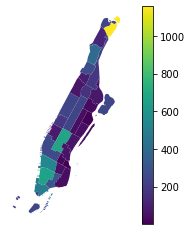

In [ ]:
NTAsubwayCent.plot(column='cccount',legend=True)
plt.axis('off')

In [ ]:
covid_trips = gpd.read_file('drive/MyDrive/IUDI Final Project/output/covid_trips')

covid_trips.head()

,OBJECTID,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Leng,Shape_Le_1,Shape_Area,Count_,Avg_pointi,Avg_grid_c,CASE_RATE,n_19,change,perc_chang,geometry
0,1,1,Manhattan,061,MN15,Clinton,34481.628773,34481.605660,1.836215e+07,43630,8.427355e+05,2296.806677,2296.806677,9038938,-5672306.0,-0.627541,"POLYGON ((985958.652 220876.750, 985970.759 22..."
1,2,1,Manhattan,061,MN25,Battery Park City-Lower Manhattan,43738.496041,43738.183813,1.901426e+07,38652,1.412032e+06,1775.924672,1775.924672,2111228,-1383102.0,-0.655117,"MULTIPOLYGON (((984032.884 192223.748, 983984...."
2,3,1,Manhattan,061,MN14,Lincoln Square,19869.908314,19869.681573,1.580552e+07,39251,7.283790e+05,1542.954969,1542.954969,6684953,-4178459.0,-0.625054,"POLYGON ((991173.649 222552.152, 991046.810 22..."
3,4,1,Manhattan,061,MN17,Midtown-Midtown South,27032.700221,27032.583487,3.019157e+07,73476,9.416262e+05,2239.991558,2239.991558,18725753,-11751647.0,-0.627566,"POLYGON ((991725.244 217725.299, 992169.505 21..."
4,5,1,Manhattan,061,MN40,Upper East Side-Carnegie Hill,23778.410362,23778.410362,2.006536e+07,50158,7.310517e+05,1784.171453,1784.171453,7720335,-4646194.0,-0.601812,"POLYGON ((998281.392 225347.967, 998145.231 22..."


In [ ]:
NTAsubwayCentTrips = pd.merge(NTAsubwayCent,covid_trips[['perc_chang','NTACode']],on='NTACode',how='left')
NTAsubwayCentTrips = gpd.GeoDataFrame(NTAsubwayCentTrips,geometry='geometry')
NTAsubwayCentTrips.to_file('drive/MyDrive/IUDI Final Project/output/centrality_trips')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
ols = sm.ols(formula = "perc_chang ~ ccmean", data = NTAsubwayCentTrips).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             perc_chang   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     3.505
Date:                Thu, 17 Dec 2020   Prob (F-statistic):             0.0721
Time:                        22:08:22   Log-Likelihood:                 50.105
No. Observations:                  29   AIC:                            -96.21
Df Residuals:                      27   BIC:                            -93.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0771      0.257     -4.192      0.000      -1.604      -0.550
ccmean       787.0604    420.412      1.872      0.072     -75.554    1649.675
==============================================================================
Omnibus:                        7.949   Durbin-Watson:                   1.475
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                6.149
Skew:                           0.975   Prob(JB):                       0.0462
Kurtosis:                       4.134   Cond. No.                     5.08e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.08e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


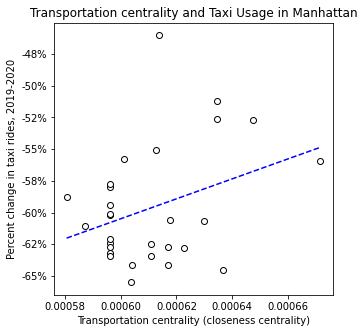

In [ ]:
plt.figure(figsize = (5,5))
plt.scatter(NTAsubwayCentTrips['ccmean'], NTAsubwayCentTrips['perc_chang'], color='white', edgecolor='k')
plt.xlabel("Transportation centrality (closeness centrality)")
plt.ylabel("Percent change in taxi rides, 2019-2020")
plt.title("Transportation centrality and Taxi Usage in Manhattan")


x1 = NTAsubwayCentTrips['ccmean'].min()
x2 = NTAsubwayCentTrips['ccmean'].max()
y1 = ols.params[0] + (ols.params[1] * x1)
y2 = ols.params[0] + (ols.params[1] * x2)

plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.plot([x1, x2], [y1, y2], linestyle = '--', color = 'blue')

(-74.0547850212659, -73.89959848882431, 40.673119138155215, 40.88885239661439)

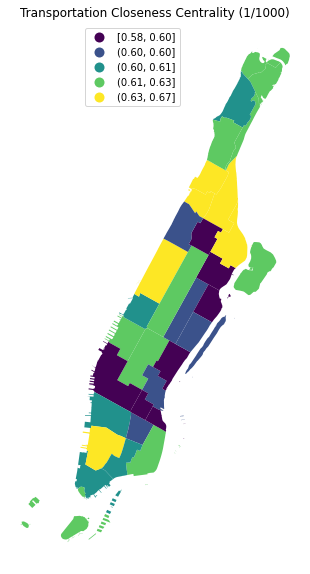

In [ ]:
NTAsubwayCentTrips["ccmean_mod"] = NTAsubwayCentTrips["ccmean"]*1000
plt1 = NTAsubwayCentTrips.plot(figsize = (10,10), column = "ccmean_mod", scheme = "quantiles", legend = True)

leg = plt1.get_legend()
leg.set_bbox_to_anchor((0.6,1))
plt.title("Transportation Closeness Centrality (1/1000)")
plt.axis(False)